In [1]:
import mne, warnings # done in mac m1
import numpy as np # done in mac m1
from itertools import chain
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
import scipy.io
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')

### Feature extraction

In [2]:
def get_feature(data):
    channel_no = [0, 2, 16, 19] # only taking these four channels
    feature_matrix = []
    for ith_video in range(data.shape[0]):
        features = []
        for ith_channel in channel_no:
            # power spectral density
            psd, freqs = plt.psd(data[ith_video][ith_channel], Fs = 128)
            # get frequency bands mean power
            theta_mean = np.mean(psd[np.logical_and(freqs >= 4, freqs <= 7)])
            alpha_mean = np.mean(psd[np.logical_and(freqs >= 8, freqs <= 13)])
            beta_mean  = np.mean(psd[np.logical_and(freqs >= 13, freqs <= 30)])
            gamma_mean = np.mean(psd[np.logical_and(freqs >= 30, freqs <= 40)])
            features.append([theta_mean, alpha_mean, beta_mean, gamma_mean])
        # flatten the features i.e. transform it from 2D to 1D
        feature_matrix.append(np.array(list(chain.from_iterable(features))))
    return np.array(feature_matrix)

### Class labels

In [3]:
def get_class_labels(labels, class_type):
    # encoding
    num_labels = labels.shape[0]
    emotion = np.ones(num_labels)
    if(class_type=='valence'):
        for i in range(0, num_labels):
            if labels[i][0]>=5:
                emotion[i] = 0
            else:
                emotion[i] = 1
    elif(class_type=='arousal'):
        for i in range(num_labels):
            if labels[i][1]>=5:
                emotion[i] = 0
            else:
                emotion[i] = 1
    else:
        for i in range(num_labels):
            if(labels[i][0]>=5 and labels[i][1] >=5): # HVHA
                emotion[i] = 0
            elif(labels[i][0]>=5 and labels[i][1]<5): #HVLA
                emotion[i] = 1
            elif(labels[i][0]<5 and labels[i][1]>=5): #LVHA
                emotion[i] = 2
            else: #LVLA
                emotion[i] = 3
    return emotion

In [4]:
# Function to apply sliding window
def apply_sliding_window(data, window_size, overlap_size, sampling_rate):
    trials, channels, time_steps = data.shape
    window_size_in_samples = int(window_size * sampling_rate)
    overlap_size_in_samples = int(overlap_size * sampling_rate)

    new_time_steps = int((time_steps - window_size_in_samples) / overlap_size_in_samples) + 1

    # Initialize an empty array for the new data
    new_data = np.zeros((trials, channels, new_time_steps, window_size_in_samples))

    # Apply sliding window
    for trial in range(trials):
        for channel in range(channels):
            for i in range(new_time_steps):
                start_idx = i * overlap_size_in_samples
                end_idx = start_idx + window_size_in_samples
                new_data[trial, channel, i, :] = data[trial, channel, start_idx:end_idx]

    return new_data

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### dataset class

In [6]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

class DEAPDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

        # Standardize the data
        scaler = StandardScaler()
        self.features = scaler.fit_transform(features)

        assert self.features.shape[0] == self.labels.shape[0]

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):

        sample_features = self.features[idx]
        sample_labels = self.labels[idx]

        features = torch.tensor(sample_features, dtype=torch.float32).to(device)
        labels = torch.tensor(sample_labels, dtype=torch.float32).to(device)

        return features, labels

### model class

In [7]:
import torch
import torch.nn as nn

# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.batch_norm2 = nn.BatchNorm1d(num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        # x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.batch_norm2(x)
        x = self.softmax(x)
        return x

### Initialization of hyperparameters

In [29]:
# model-related parameters
batch_size = 12
learning_rate = 0.001
num_epochs = 100
hidden_size = 50
weight_decay = 0#1e-5

# data-related paramters
window_size = 10
overlap_size = 5

In [30]:
subject_no = 's01'
# read the data
dataset_path = '../data/deap/'
deap_dataset = scipy.io.loadmat(dataset_path + subject_no + '.mat')

In [31]:
# separate data and labels
data = np.array(deap_dataset['data']) # for current data
labels = np.array(deap_dataset['labels']) # for current labels
# remove 3sec pre baseline
data  = data[0:40,0:32,384:8064]

In [32]:
# Parameters
sampling_rate = 128

# Apply sliding window to EEG data
new_data = apply_sliding_window(data, window_size, overlap_size, sampling_rate)

# Print the shape of the resulting data
print("Original data shape:", data.shape)
print("Sliding window data shape:", new_data.shape)


Original data shape: (40, 32, 7680)
Sliding window data shape: (40, 32, 11, 1280)


In [33]:
windowed_data = new_data.reshape(-1, new_data.shape[1], new_data.shape[3])
windowed_labels = np.repeat(labels, new_data.shape[2], axis=0)
print(f"Windowed data shape: {windowed_data.shape}")
print(f"Windowed labels shape: {windowed_labels.shape}")

Windowed data shape: (440, 32, 1280)
Windowed labels shape: (440, 4)


Features shape: (440, 16)


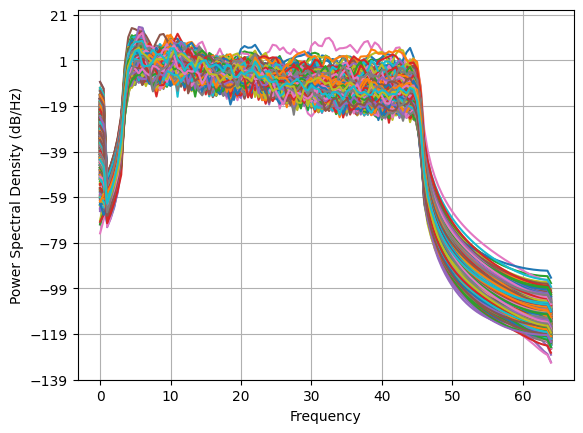

In [34]:
# channel_no = [0, 2, 16, 19] # only taking these four channels
# features = windowed_data[:,channel_no,:].reshape(windowed_data.shape[0], -1)
features = get_feature(windowed_data)
print(f"Features shape: {features.shape}")

In [35]:
# features = get_feature(data)
valence_labels = get_class_labels(windowed_labels, 'valence')
arousal_labels = get_class_labels(windowed_labels, 'arousal')
four_labels = get_class_labels(windowed_labels, 'four')
print(f"Labels shape: {four_labels.shape}")

Labels shape: (440,)


In [36]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, four_labels, test_size=0.2, random_state=42)
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (281, 16)
Validation shape: (71, 16)
Test shape: (88, 16)


In [37]:
from torch.utils.data import DataLoader
train_torch= DEAPDataset(X_train, y_train)
train_dataloader = DataLoader(train_torch, batch_size=batch_size, shuffle=True)


In [38]:
from torch.utils.data import DataLoader
val_torch = DEAPDataset(X_val, y_val)
val_dataloader = DataLoader(val_torch, batch_size=batch_size, shuffle=True)

In [39]:
test_torch = DEAPDataset(X_test, y_test)
test_dataloader = DataLoader(test_torch, batch_size=1, shuffle=True)

In [40]:
model = MLPClassifier(input_size=features.shape[1], hidden_size= hidden_size, num_classes=len(np.unique(four_labels)))
model.to(device)

MLPClassifier(
  (fc1): Linear(in_features=16, out_features=50, bias=True)
  (batch_norm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=4, bias=True)
  (batch_norm2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)

In [41]:
import torch
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_epoch_loss = 0.0
    train_correct_predictions = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels.long())
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct_predictions += (predicted == labels).sum().item()


        with torch.no_grad():
            val_epoch_loss = 0.0
            for val_inputs, val_labels in val_dataloader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels.long())
                val_epoch_loss += val_loss.item()


    average_train_loss = train_epoch_loss / len(train_dataloader.dataset)
    accuracy = train_correct_predictions / len(train_dataloader.dataset)
    train_losses.append(average_train_loss)

    average_val_loss = val_epoch_loss / len(val_dataloader.dataset)
    val_losses.append(average_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}] => Train Loss: {average_train_loss:.4f}, Accuracy: {accuracy:.4f} | Validation Loss {average_val_loss:.4f}')


Epoch [1/100] => Train Loss: 0.1181, Accuracy: 0.2847 | Validation Loss 0.1168
Epoch [2/100] => Train Loss: 0.1171, Accuracy: 0.3488 | Validation Loss 0.1159
Epoch [3/100] => Train Loss: 0.1164, Accuracy: 0.3630 | Validation Loss 0.1154
Epoch [4/100] => Train Loss: 0.1157, Accuracy: 0.3737 | Validation Loss 0.1151
Epoch [5/100] => Train Loss: 0.1154, Accuracy: 0.3986 | Validation Loss 0.1147
Epoch [6/100] => Train Loss: 0.1147, Accuracy: 0.4093 | Validation Loss 0.1145
Epoch [7/100] => Train Loss: 0.1141, Accuracy: 0.4235 | Validation Loss 0.1141
Epoch [8/100] => Train Loss: 0.1136, Accuracy: 0.4128 | Validation Loss 0.1138
Epoch [9/100] => Train Loss: 0.1133, Accuracy: 0.4128 | Validation Loss 0.1135
Epoch [10/100] => Train Loss: 0.1133, Accuracy: 0.4306 | Validation Loss 0.1132
Epoch [11/100] => Train Loss: 0.1125, Accuracy: 0.4342 | Validation Loss 0.1130
Epoch [12/100] => Train Loss: 0.1121, Accuracy: 0.4306 | Validation Loss 0.1128
Epoch [13/100] => Train Loss: 0.1120, Accuracy: 0

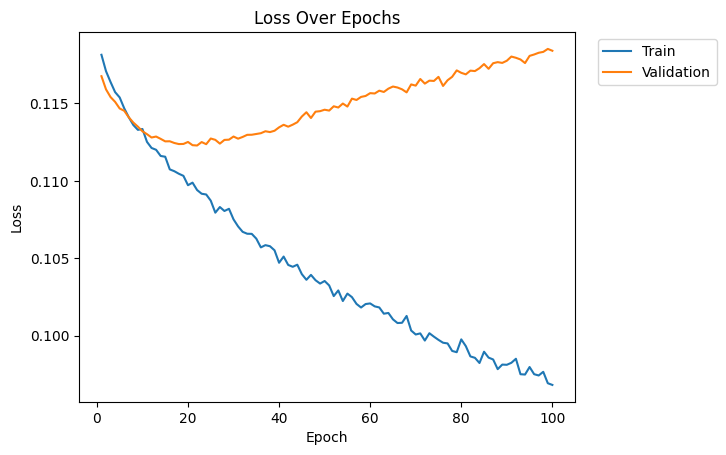

In [42]:
# Visualize the training loss graph
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [22]:
# model_path = '../model/MLP.pt'
# torch.save(model, model_path)

In [23]:
# model = torch.load(model_path)

In [43]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [44]:
# Evaluate on the test set
model.eval()
idx = 0
intermediate_features = []

model.softmax.register_forward_hook(get_activation('softmax'))

with torch.no_grad():
    correct_predictions = 0

    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        # print(test_outputs)
        _, predicted_labels = torch.max(test_outputs, 1)

        intermediate_features.append(activation['softmax'].cpu().numpy())

        print(f"Trial[{idx+1}] prediction: {int(predicted_labels)}, truth: {int(test_labels)}")
        idx += 1

        correct_predictions += (predicted_labels == test_labels).sum().item()

    test_accuracy = correct_predictions / len(test_dataloader.dataset)
    print(f'Test Accuracy: {test_accuracy:.4f}')

Trial[1] prediction: 3, truth: 2
Trial[2] prediction: 0, truth: 1
Trial[3] prediction: 3, truth: 0
Trial[4] prediction: 3, truth: 2
Trial[5] prediction: 2, truth: 2
Trial[6] prediction: 2, truth: 3
Trial[7] prediction: 0, truth: 3
Trial[8] prediction: 2, truth: 3
Trial[9] prediction: 2, truth: 0
Trial[10] prediction: 2, truth: 1
Trial[11] prediction: 0, truth: 0
Trial[12] prediction: 0, truth: 1
Trial[13] prediction: 0, truth: 1
Trial[14] prediction: 2, truth: 0
Trial[15] prediction: 3, truth: 0
Trial[16] prediction: 2, truth: 0
Trial[17] prediction: 3, truth: 0
Trial[18] prediction: 0, truth: 0
Trial[19] prediction: 3, truth: 2
Trial[20] prediction: 0, truth: 3
Trial[21] prediction: 3, truth: 3
Trial[22] prediction: 2, truth: 0
Trial[23] prediction: 0, truth: 3
Trial[24] prediction: 0, truth: 3
Trial[25] prediction: 0, truth: 2
Trial[26] prediction: 2, truth: 2
Trial[27] prediction: 3, truth: 0
Trial[28] prediction: 2, truth: 0
Trial[29] prediction: 0, truth: 2
Trial[30] prediction: 2

In [45]:
for i in range(len(intermediate_features)):
    print(f"Trial[{i+1}] {intermediate_features[i]}")

Trial[1] [[0.15350081 0.00467949 0.01152769 0.83029205]]
Trial[2] [[8.9800215e-01 3.1832003e-04 3.5538562e-02 6.6140965e-02]]
Trial[3] [[0.2834289  0.01331509 0.05809653 0.6451594 ]]
Trial[4] [[3.6854947e-01 1.0671907e-04 3.2097455e-02 5.9924638e-01]]
Trial[5] [[0.24110642 0.01794971 0.69257677 0.04836714]]
Trial[6] [[0.01709528 0.0107525  0.9236945  0.0484578 ]]
Trial[7] [[0.60031295 0.00946171 0.37034154 0.01988379]]
Trial[8] [[0.2607546  0.00128002 0.7049865  0.03297884]]
Trial[9] [[0.41234368 0.0111498  0.53860146 0.03790507]]
Trial[10] [[0.32600248 0.0248548  0.3286179  0.32052487]]
Trial[11] [[0.6062951  0.02321127 0.08149391 0.28899968]]
Trial[12] [[0.63145006 0.00851799 0.30521005 0.05482193]]
Trial[13] [[9.1592258e-01 3.8891674e-05 1.0288349e-05 8.4028222e-02]]
Trial[14] [[0.03088873 0.00579102 0.95079374 0.01252659]]
Trial[15] [[1.4383403e-03 6.5947188e-07 1.5441346e-06 9.9855942e-01]]
Trial[16] [[0.32233468 0.01834054 0.3470871  0.31223768]]
Trial[17] [[4.6243382e-01 4.35218

In [27]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 1. 기본 스타일 설정
# plt.style.use('default')
# plt.rcParams['figure.figsize'] = (5, 3)
# plt.rcParams['font.size'] = 12

# # 2. 데이터 준비
# np.random.seed(0)
# data_a = np.random.normal(6.8, 1, 10)
# data_b = np.random.normal(5.9, 1.5, 100)
# data_c = np.random.normal(3.3, 1.5, 100)
# data_d = np.random.normal(4, 1.5, 100)

# # 3. 그래프 그리기
# fig, ax = plt.subplots()

# ax.boxplot([data_a, data_b, data_c, data_d])
# ax.set_ylim(1.0, 9.0)
# ax.set_xlabel('Data Type')
# ax.set_ylabel('Likert-scale')
# ax.set_title('Q4 (HVLA)')
# ax.set_xticklabels(['MD-V', 'GM-V', 'MD-A', 'GM-A'])

# plt.show()

In [28]:
# import muspy

# # Load a MIDI file using MusPy
# data_file_path = "../data/emopia/EMOPIA_1.0/midis/Q1__8v0MFBZoco_0.mid"
# target_file_path = "../midi/test9_emotion[1].mid"
# score = muspy.read_midi(target_file_path)

# # Extract Pitch Range
# pitch_range = muspy.pitch_range(score)

# # # Extract Number of Pitch Classes per Bar
# num_pitch_classes_per_bar = muspy.n_pitch_classes_used(score)

# # # Extract Polyphony
# polyphony = muspy.polyphony(score)

# # Print or use the extracted features
# print("Pitch Range:", pitch_range)
# print("Number of Pitch Classes per Bar:", num_pitch_classes_per_bar)
# print("Polyphony:", polyphony)
